# **Pakistani Multi-Source News Mining**
### *By Abdur Rafey, Abdul Mateen, and Daniyal Qadir*   
<br>

This notebook implements a complete **NLP-based data mining pipeline** { Full Dataset + Preprocessing + Feature Engineering + Statistical Analysis + Exploratory Data Analysis + Classical ML + Transformer + Clustering + Association Rule Mining } on a Pakistani multi-source news dataset.

It demonstrates:

- End-to-end text preprocessing and feature engineering.
- Supervised news classification (classical ML + DistilBERT).
- Unsupervised clustering for latent topic discovery.
- Simple association-style pattern mining using categories, sources and time.
- A reusable prediction helper and saved model for deployment.

> **Execution note:** If running locally, place all five CSV files in the same folder as this notebook. Additionally, cells are chronological (structure below), so run them from top to bottom.

```text
[Raw News CSVs] → [Cleaning] → [EDA] → [Models] → [Clustering & Rules] → [Insights]
```
<br>

<p align="center">
SIMPLIFIED MINING PIPELINE FLOWCHART
  <img src="https://drive.google.com/uc?export=view&id=1TMysIzwt0fYuOd9PIlc2_AOVKyff7cnb" width="1200">
</p>

## **0. Environment and Configuration**


This section imports the required Python libraries, configures plotting styles, and defines a few global constants.

In [ ]:
# Section 0: Imports and global configuration.



!pip install -q --upgrade "transformers>=4.40.0" "datasets>=2.19.0" "evaluate>=0.4.0"

import re
from pathlib import Path
from dataclasses import dataclass
from IPython.display import Markdown
from collections import Counter, defaultdict
from typing import List, Dict, Tuple, Iterable, Optional

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, f1_score, silhouette_score,)


# Plot styling.
sns.set_theme(style="whitegrid")
sns.set_palette(sns.cubehelix_palette(start=0.5, rot=-0.75, light=0.85))

plt.rcParams.update({
    "figure.dpi": 150,
    "figure.figsize": (10, 6),
    "axes.labelweight": "bold",
    "font.size": 12
})


RANDOM_STATE = 42
TOP_K_CATEGORIES = 20
MIN_SUPPORT = 0.01

RUN_BERT = True  # True: B.E.R.T. is fine-tuned on the full dataset; False: it's not.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 144.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 57.6 MB/s eta 0:00:00


### **0.1 Dataset Uploading**

This project uses **five raw news CSV files**, each representing a different Pakistani news source:

- **Business Recorder.csv**  
- **Daily Times.csv**  
- **Dawn.csv**  
- **Pakistan Today.csv**  
- **Tribune.csv**

Across all sources, the main columns of interest are:

- **headline** — the article’s title  
- **description** — the article’s summary/body  
- **categories** — assigned category or tag (may contain variants/spelling differences)  
- **source_file** — name of the original CSV file  
- **date** — publication timestamp (varies in format)

The size of the dataset is about 2.1 GBs.


In [ ]:
# Section 0.1: Dataset Uploading.



!gdown --folder --fuzzy "https://drive.google.com/drive/folders/1RQ_EaGH3aJ8HNvT0dXYmY80i8WGMz0zp?usp=sharing"

Retrieving folder contents
Processing file 1GqF_M9GpnIv9SEtYLtajp88x1G1U1GK1 Business Recorder.csv
Processing file 1gBwSrB16qTGkmREG0rmfOYvIpWuG28Jx Daily Times.csv
Processing file 1VuDd3nnGgyEbdTihFcDtBgrlSe0uOH4n Dawn.csv
Processing file 1N1el8YxUO31YeUjlOksZZyQPYQkkv8KL Pakistan Today.csv
Processing file 1bjjzWbpSUaneq2PN8CM8T11bwPnEbdX6 Tribune.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1GqF_M9GpnIv9SEtYLtajp88x1G1U1GK1
From (redirected): https://drive.google.com/uc?id=1GqF_M9GpnIv9SEtYLtajp88x1G1U1GK1&confirm=t&uuid=ea4207cf-a316-46b9-963d-5796aa3d6b10
To: /content/News/Business Recorder.csv
100% 1.07G/1.07G [00:09<00:00, 118MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1gBwSrB16qTGkmREG0rmfOYvIpWuG28Jx
From (redirected): https://drive.google.com/uc?id=1gBwSrB16qTGkmREG0rmfOYvIpWuG28Jx&confirm=t&uuid=3197accb-8e35-4559-b09e-6409b9e

## **1. Dataset Loading and Integration**


Here we load the **5 Pakistani News CSV Files (Business Recorder, Daily Times, Dawn, Pakistan Today, and Tribune)**, attach a `source_file` tag to each row, and concatenate everything into one unified DataFrame that our models can process.

Some of what we do:
- Read the CSVs from Business Recorder, Daily Times, Dawn, Pakistan Today and Tribune.
- Drop un-named junk columns.
- Ensure columns ( `headline` , `description` , `categories` , `source` , `date`  , and `link` ) exist and 'work'.
- Fill missing values in the columns.
- Convert the format of the date column.

At the end, we get the raw shape of our dataset and what a record in it looks like.

In [ ]:
# Section 1: Dataset Loading and Integration.



csv_files = [
    "Business Recorder.csv",
    "Daily Times.csv",
    "Dawn.csv",
    "Pakistan Today.csv",
    "Tribune.csv",
]

frames = []

for path_str in csv_files:
    path_obj = Path(path_str)
    if not path_obj.exists():
        raise FileNotFoundError(f"Required file is missing: {path_str}.")
    df_i = pd.read_csv(path_obj, encoding="latin1", low_memory=False)
    df_i["source_file"] = path_obj.stem
    frames.append(df_i)

df_raw = pd.concat(frames, ignore_index=True)


# Drops unnamed columns; for testing.
df_raw = df_raw.loc[:, ~df_raw.columns.str.startswith("Unnamed")]

# Verifies column structure; for testing.
for col in ["headline", "description", "categories", "source", "date", "link"]:
    if col not in df_raw.columns:
        df_raw[col] = np.nan


"""
Fills missing values and  as follows:
- Empty string if the Headline or the Description is not specified, so our models work.
- "Unknown" for category, so we can still produce stats. and analyze for articles w.o. a category.
- Source file name for Source (if source is Dawn.csv, name is Dawn).
- Coverts date column values from date-time format to a string.
"""
df_raw["headline"] = df_raw["headline"].fillna("").astype(str)
df_raw["description"] = df_raw["description"].fillna("").astype(str)
df_raw["categories"] = df_raw["categories"].fillna("Unknown").astype(str).str.strip()

df_raw["source"] = (
    df_raw["source"]
    .fillna(df_raw["source_file"].str.replace(r"\.csv$", "", regex=True))
    .astype(str)
    .str.strip()
)

df_raw["date"] = df_raw["date"].astype(str)


print("Raw shape:", df_raw.shape)
df_raw.head()

Raw shape: (625905, 7)


,headline,date,link,source,categories,description,source_file
0,2019: A tough year it was indeed,1/1/2020,https://www.brecorder.com/news/557945/two-019-...,Business Recorder,Editorials,"[caption id=""attachment_524853"" align=""alignno...",Business Recorder
1,The matter of ECP appointments,1/1/2020,https://www.brecorder.com/news/557946/the-matt...,Business Recorder,Editorials,Delaying important decisions and making them d...,Business Recorder
2,PTA plans to procure automated QoS monitoring ...,1/1/2020,https://www.brecorder.com/news/557922/pta-plan...,Business Recorder,Technology,Pakistan Telecommunication Authority (PTA) has...,Business Recorder
3,"Number of 3G, 4G users reaches 74.33 million b...",1/1/2020,https://www.brecorder.com/news/557925/number-o...,Business Recorder,Technology,The number of 3G and 4G users in Pakistan reac...,Business Recorder
4,China to cut reserve requirement for banks as ...,1/1/2020,https://www.brecorder.com/news/557995/china-to...,Business Recorder,Business & Finance,The central bank cut the requirement three tim...,Business Recorder


## **2. Unified Text and Category Cleaning**


We construct a single free-text field `STORY` by merging `headline` and `description` , and we standardize the category labels.

Steps:
- Create `STORY = headline + description`.
- Normalize small label variations (for example, `Sport` → `Sports` ) .
- Keep only the **top 20 most frequent categories** and encode them as numeric labels.

This gives us a filtered dataset, which we see in part, and for which we show the shape alongside the categories it was filtered based-on.

In [ ]:
# Section 2: Unified Text and Category Cleaning.



# Merges the Headline and Description cols. into a col. Story.
df_raw["STORY"] = (df_raw["headline"] + " " + df_raw["description"]).str.strip()


# Maps the spelling mistakes/versions of categories (only ones we found).
CATEGORY_MAP = {
    "Sport": "Sports",
    "sport": "Sports",
    "sports": "Sports",
    "Tech": "Technology",
}

# Cleans categories using the cat. map.
df_raw["category_clean"] = df_raw["categories"].replace(CATEGORY_MAP).str.strip()


# Records categories.
top_categories = (
    df_raw["category_clean"]
    .value_counts()
    .head(TOP_K_CATEGORIES)
    .index
    .tolist()
)

# Matches categories to their labels.
df = df_raw[df_raw["category_clean"].isin(top_categories)].copy()
df["label"] = df["category_clean"].astype("category").cat.codes

label_to_category = dict(
    enumerate(df["category_clean"].astype("category").cat.categories)
)

category_to_label = {v: k for k, v in label_to_category.items()}


# Styles and displays some statistics and a plot.
print("The Top Categories We Used:", top_categories)
print("The Dataset's Filtered Shape:", df.shape)

df_display = df[["headline", "category_clean", "source"]].copy()
df_display.columns = ["Headline.", "Cleaned Category.", "Source."]

df_display.head()

The Top Categories We Used: ['Pakistan', 'World', 'Markets', 'Sports', 'Business', 'Business & Finance', 'NATIONAL', 'Lifestyle', 'Print', 'Technology', 'Opinion', 'Op-Ed', 'Pakistan & Top Stories', 'Reviews', 'Life & Style', 'Editorial', 'BR Research', 'Punjab', 'NATIONAL & Top Headlines', 'Sindh']
The Dataset's Filtered Shape: (567495, 10)


,Headline.,Cleaned Category.,Source.
2,PTA plans to procure automated QoS monitoring ...,Technology,Business Recorder
3,"Number of 3G, 4G users reaches 74.33 million b...",Technology,Business Recorder
4,China to cut reserve requirement for banks as ...,Business & Finance,Business Recorder
5,UK's Lloyds Banking Group reports disruption t...,Business & Finance,Business Recorder
6,Strike not extended at Lufthansa's Germanwings...,Business & Finance,Business Recorder


## **3. Exploratory Data Analysis: Summary Statistics**


In this part we compute basic descriptive statistics on:

- Article length (characters and words).
- Overall category distribution.
- Parsed publication dates.

These summary tables give a quick sense of dataset size and category balance before we train our models. Some models, like DistilBERT, cannot tolerate extreme class imbalances. Seems like that is not going to an issue.

The subsections will offer additional detail as you progress through this section.


In [ ]:
# Section 3: Exploratory Data Analysis: Summary Statistics.



# Computes derived columns for later analysis (see Section 3.1: Category Distribution and Length Patterns).
df["story_len_chars"] = df["STORY"].str.len()
df["story_len_words"] = df["STORY"].str.split().str.len()
df["date_parsed"] = pd.to_datetime(df["date"], errors="coerce")


# Styles the plot (Categorical Count).
cat_counts = df["category_clean"].value_counts().reset_index()
cat_counts.columns = ["Category.", "Count."]

(
    cat_counts.style
    .background_gradient(cmap="Reds", subset=["Count."])
    .bar(subset=["Count."], color="#ffb3c6")
    .set_properties(
        subset=["Count."],
        **{
            "color": "black",
            "font-weight": "bold",
        }
    )
    .set_properties(**{"border": "1px solid black"})
)

,Category.,Count.
0,Pakistan,146579
1,World,95424
2,Markets,86233
3,Sports,56577
4,Business,46501
5,Business & Finance,26914
6,NATIONAL,20692
7,Lifestyle,20525
8,Print,15454
9,Technology,8998


### **3.1 Category Distribution and Length Patterns**


The next plots show:

- A bar chart of **category frequencies** (Figure: Category Distribution).
- A histogram of **story lengths** in words (Figure: Story Length Distribution).
- A boxplot of **story length by category** (Figure: Length by Category).

Together, they highlight which topics dominate the corpus and how detailed the typical article is.

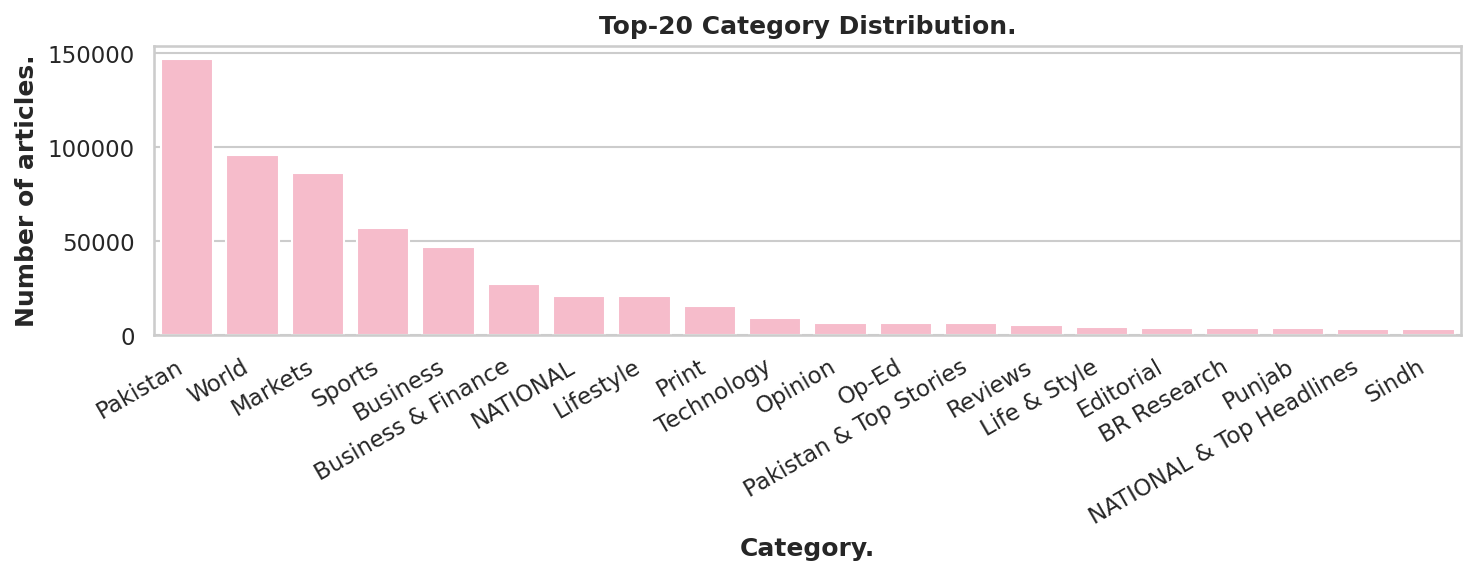

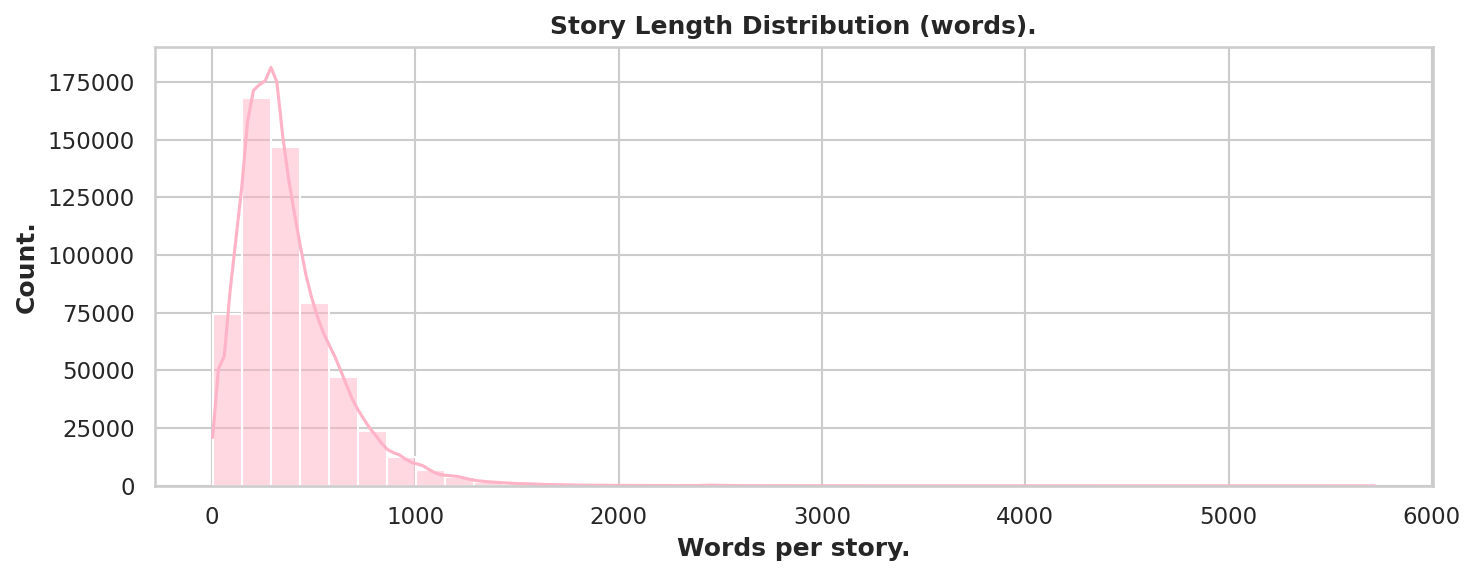

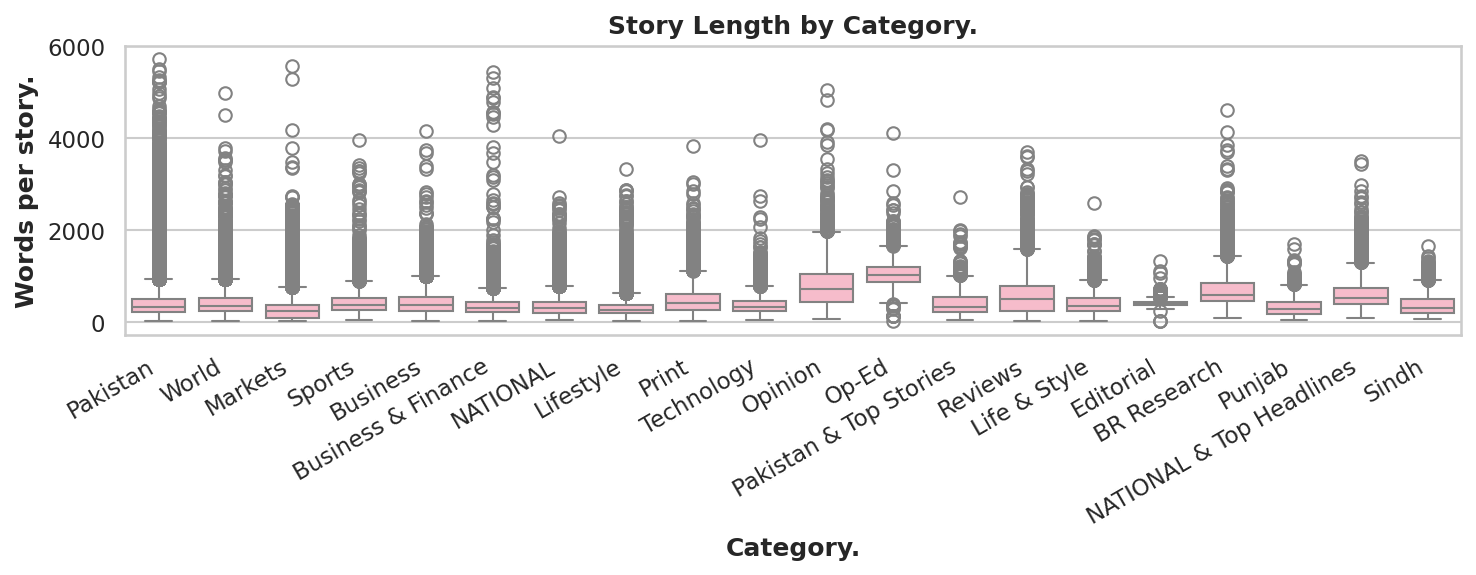

In [ ]:
"""
Section 3.1: Category Distribution and Length Patterns.

Shows, in order:
- A bar chart of category frequencies (Figure: Category Distribution).
- A histogram of story lengths in words (Figure: Story Length Distribution).
- A boxplot of story length by category (Figure: Length by Category).
"""



plt.figure(figsize=(10, 4))
sns.barplot(data=cat_counts, x="Category.", y="Count.", color="#ffb3c6")
plt.title("Top-20 Category Distribution.", fontweight="bold")
plt.xlabel("Category.")
plt.ylabel("Number of articles.")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

print("\n\n")


plt.figure(figsize=(10, 4))
sns.histplot(
    df["story_len_words"],
    bins=40,
    kde=True,
    color="#ffb3c6"
)

plt.title("Story Length Distribution (words).", fontweight="bold")
plt.xlabel("Words per story.")
plt.ylabel("Count.")
plt.tight_layout()
plt.show()

print("\n\n")


plt.figure(figsize=(10, 4))
order = df["category_clean"].value_counts().index
sns.boxplot(
    data=df,
    x="category_clean",
    y="story_len_words",
    order=order,
    color="#ffb3c6"
)

plt.title("Story Length by Category.", fontweight="bold")
plt.xlabel("Category.")
plt.ylabel("Words per story.")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

### **3.2 Source vs Category Relationship**


We now examine how **different news outlets** allocate coverage across categories.

- A heatmap of `source × category` counts reveals strong preferences.

The styled table under the heatmap, by showing source x category count, makes it easy to see which outlet focuses on which topics.

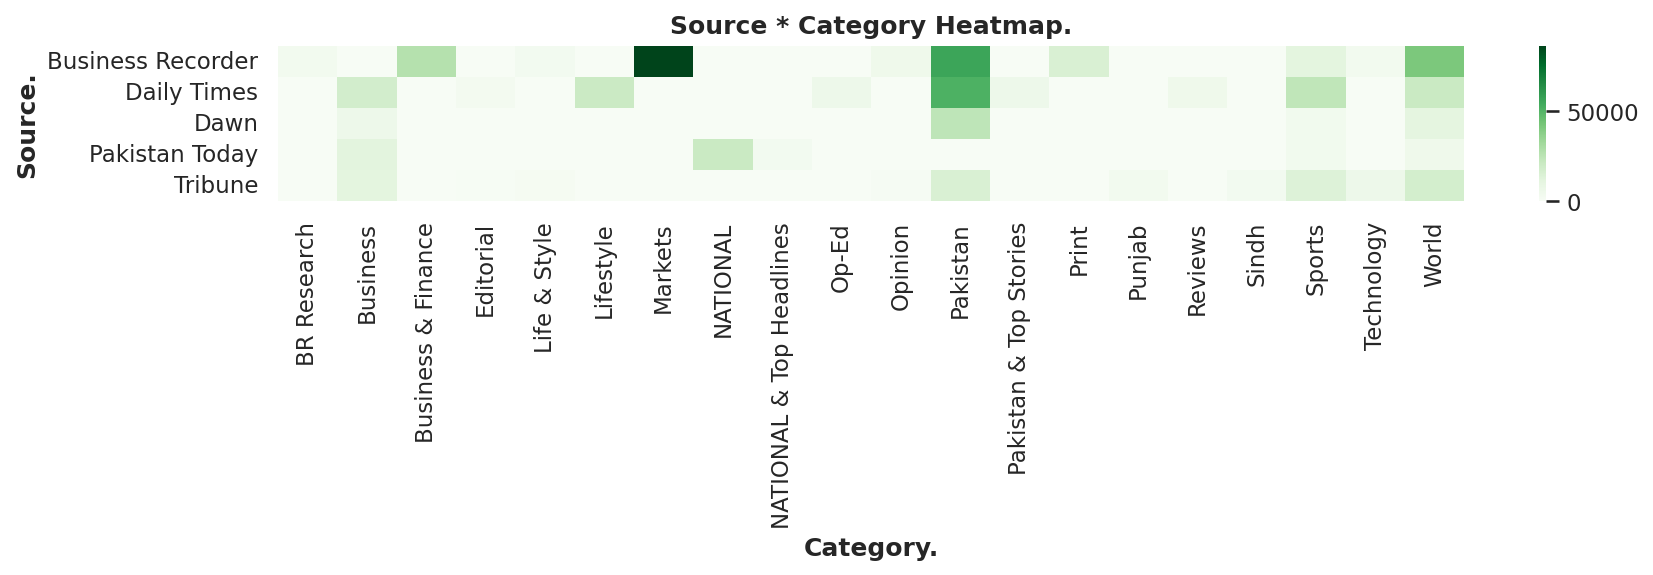

category_clean,BR Research,Business,Business & Finance,Editorial,Life & Style,Lifestyle,Markets,NATIONAL,NATIONAL & Top Headlines,Op-Ed,Opinion,Pakistan,Pakistan & Top Stories,Print,Punjab,Reviews,Sindh,Sports,Technology,World
source,,,,,,,,,,,,,,,,,,,,
Business Recorder,3281,102,26904,0,2722,0,86233,0,0,0,5252,55910,0,15454,0,0,0,11211,3198,41343
Daily Times,0,17538,10,2628,0,20525,0,0,0,5951,0,51364,5930,0,57,5308,56,23899,0,20723
Dawn,0,6003,0,0,0,0,0,0,0,0,0,24024,0,0,0,0,0,3980,0,10988
Pakistan Today,0,11643,0,0,0,0,0,20692,3003,0,22,0,0,0,0,0,0,3966,0,5123
Tribune,0,11215,0,770,1451,0,0,0,0,0,1127,15281,0,0,3187,0,2853,13521,5800,17247


In [ ]:
# Section 3.2: Source vs Category Relationship.



# Heatmap.
pivot = pd.crosstab(df["source"], df["category_clean"])

plt.figure(figsize=(12, 4))
sns.heatmap(pivot, cmap="Greens")
plt.title("Source * Category Heatmap.", fontweight = "bold")
plt.xlabel("Category.")
plt.ylabel("Source.")
plt.tight_layout()
plt.show()

print("\n\n")


# Same information, this time w. count.
pivot.style.background_gradient(cmap="Greens")

### **3.3 Temporal Trends**

Have our news sources, over time, re-evaluated the categories they prefer? We answer that question in this section.

Articles are aggregated by **month** and **category**, producing:
- a line chart that highlights peaks and valleys but also stability, by category and over time.

We interpret these time-series trends in our report.

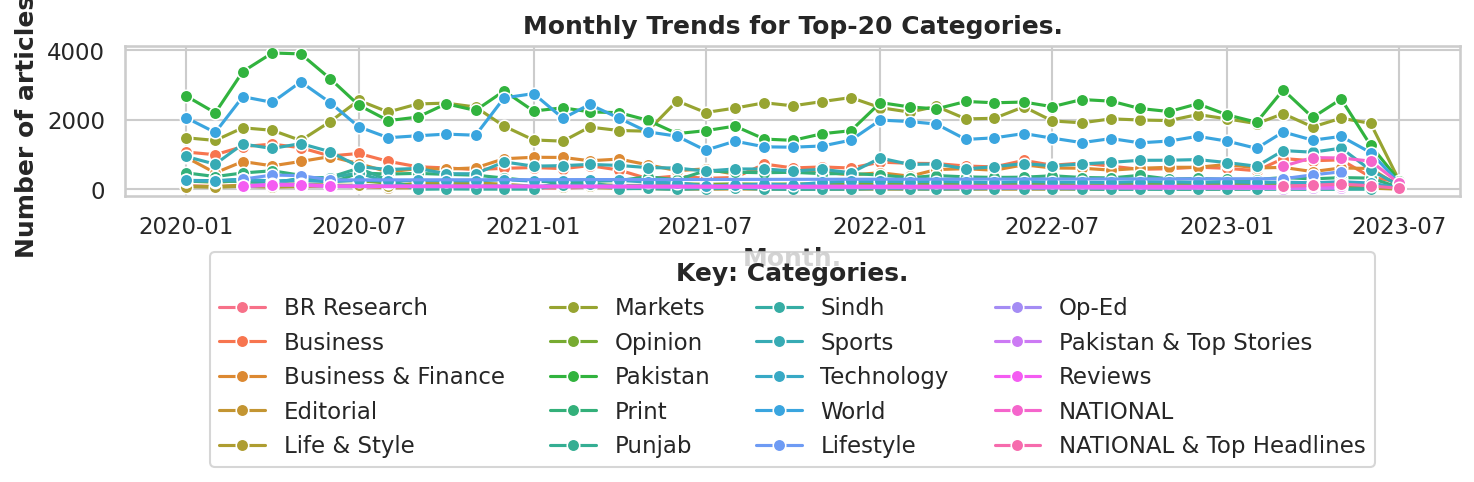

In [ ]:
# Section 3.3: Temporal Trends.



# Parses the time-series (date) element of the dataset for the time-series plot.
if df["date_parsed"].notna().any():
    df_time = df.dropna(subset=["date_parsed"]).copy()
    df_time["month"] = df_time["date_parsed"].dt.to_period("M").dt.to_timestamp()

    top20 = df_time["category_clean"].value_counts().head(TOP_K_CATEGORIES).index

    trend = (
        df_time[df_time["category_clean"].isin(top20)]
        .groupby(["month", "category_clean"])
        .size()
        .reset_index(name="count")
    )


    # Sets the plot's x, y axes.
    plt.figure(figsize=(10, 4))
    sns.lineplot(
        data=trend,
        x="month",
        y="count",
        hue="category_clean",
        marker="o",
    )


    # The legend of said plot (shows below the plot so it does not overlap w. imp. info.).
    legend = plt.legend(
        title="Key: Categories.",
        bbox_to_anchor=(0.5, -0.3),
        loc="upper center",
        ncol=4
    )


    legend.get_title().set_fontweight("bold")

    plt.title("Monthly Trends for Top-20 Categories.", fontweight="bold")
    plt.xlabel("Month.")
    plt.ylabel("Number of articles.")
    plt.tight_layout()
    plt.show()


## **4. Text Cleaning and Normalization**


We define a simple, robust text cleaner that:

- Converts to lowercase.
- Removes URLs, punctuation, and digits.
- Collapses multiple spaces.

What we remove is what we found after reading up on N.L.P. research, does not produce meaningful tokens. The cleaned text is stored in `STORY_CLEAN` and is used by all of our downstream models.

In [ ]:
# Section 4: Text Cleaning and Normalization.



# Cleans the text in the Story col. (headline + desc. remember?) to be plain (no special char.) and lower-case.
def clean_text(text: str) -> str:
    cleaned = text.lower()
    cleaned = re.sub(r"http\S+|www\S+", " ", cleaned)
    cleaned = re.sub(r"[^a-z0-9\s]", " ", cleaned)
    cleaned = re.sub(r"\d+", " ", cleaned)
    cleaned = re.sub(r"\s+", " ", cleaned).strip()
    return cleaned

df["STORY_CLEAN"] = df["STORY"].apply(clean_text)
df[["STORY", "STORY_CLEAN"]].head()


,STORY,STORY_CLEAN
2,PTA plans to procure automated QoS monitoring ...,pta plans to procure automated qos monitoring ...
3,"Number of 3G, 4G users reaches 74.33 million b...",number of g g users reaches million by end nov...
4,China to cut reserve requirement for banks as ...,china to cut reserve requirement for banks as ...
5,UK's Lloyds Banking Group reports disruption t...,uk s lloyds banking group reports disruption t...
6,Strike not extended at Lufthansa's Germanwings...,strike not extended at lufthansa s germanwings...


## **5. Train–Test Split**


The dataset is split into **training** and **test** sets using an 80/20 ratio.

- When possible, we stratify by the label so each split preserves category proportions.
- The test set is used only for final evaluation, not for model tuning.

In [ ]:
# Train–Test Split.



# A simple 80% train and 20% test split.
label_counts = df["label"].value_counts()
can_stratify = (label_counts.min() >= 2) and (df["label"].nunique() > 1)
strat_labels = df["label"] if can_stratify else None

X_train, X_test, y_train, y_test = train_test_split(
    df["STORY_CLEAN"],
    df["label"],
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=strat_labels,
)

print("Train size:", len(X_train), "| Test size:", len(X_test))

Train size: 453996 | Test size: 113499


## **6. Classical Text Classifiers with TF‑IDF**


Here we build three supervised classical ML models on top of **TF‑IDF features**:

- Multinomial Naive Bayes.
- Logistic Regression.
- Linear SVM.

We compare their accuracy and macro‑F1 scores in a small summary table. Later, we will compare the best model of the bunch with DistilBERT, a DL model. A general structure of this part of the pipeline is shown below.

```text
[STORY_CLEAN] → [TF‑IDF] [DistilBERT] → [Classifier] → [Performance Metrics]
```

In [ ]:
# Section 6: Classical Text Classifiers with TF‑IDF.



"""
This is the best these models are going to do because, in the code directly below:
- We made an intelligent decision to allow the model to use both bigrams (two words; e.g., Prime Minister) and unigrams (single words).
- We ignored words that appear in less than 0.5% of articles (too rare so noise) and more than 95% of articles (too common so irrelevant).
The only limitations now are the model architectures.
"""
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=0.005,
    max_df=0.95,
    stop_words="english",
)


# 3 classical models: Naive Bayes, Logistic Regression, and Linear S.V.M..
pipelines = {
    "Naive Bayes": Pipeline(
        [
            ("tfidf", tfidf),
            ("clf", MultinomialNB()),
        ]
    ),
    "Logistic Regression": Pipeline(
        [
            ("tfidf", tfidf),
            (
                "clf",
                LogisticRegression(
                    max_iter=4000,
                    n_jobs=-1,
                    class_weight="balanced",
                ),
            ),
        ]
    ),
    "Linear SVM": Pipeline(
        [
            ("tfidf", tfidf),
            ("clf", LinearSVC(class_weight="balanced")),
        ]
    ),
}


# Styles and displays the results.
baseline_results = []
trained_pipes = {}

for model_name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average="macro")
    baseline_results.append(
        {
            "model": model_name,
            "accuracy": acc,
            "macro_f1": macro_f1,
        }
    )
    trained_pipes[model_name] = pipe

baseline_df = (
    pd.DataFrame(baseline_results)
    .sort_values("macro_f1", ascending=False)
    .reset_index(drop=True)
)

baseline_df.style.background_gradient(cmap="OrRd").format(
    "{:.3f}", subset=["accuracy", "macro_f1"]
)

,model,accuracy,macro_f1
0,Linear SVM,0.741,0.629
1,Logistic Regression,0.676,0.598
2,Naive Bayes,0.727,0.468


### **6.1 Cross‑Validated Hyperparameter Tuning**


The best classical model from the previous step is refined using **GridSearchCV** with stratified folds.

- We sweep key hyperparameters such as `C` for linear models or `alpha` for Naive Bayes.
- The objective is to maximize macro‑F1 across categories.

This tunes our model for its 'fight' against DistilBERT!

In [ ]:
# Section 6.1: Cross‑Validated Hyperparameter Tuning.



best_name = baseline_df.iloc[0]["model"]
best_pipeline = trained_pipes[best_name]


"""
Checks to see which classical model gave the best results and:
- Defines, depending on the selected model, what hyperparameters to search for.
- Searches them, selecting the best one(s).
"""
if best_name in ["Logistic Regression", "Linear SVM"]:
    param_grid = {"clf__C": [0.3, 1, 3, 10]}
elif best_name == "Naive Bayes":
    param_grid = {"clf__alpha": [0.1, 0.5, 1.0]}
else:
    param_grid = {}

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_STATE,
)

grid = GridSearchCV(
    estimator=best_pipeline,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    scoring="f1_macro",
)

grid.fit(X_train, y_train)

best_pipeline = grid.best_estimator_
best_name = f"{best_name} (tuned)"
print("Best classical parameters:", grid.best_params_)

Best classical parameters: {'clf__C': 0.3}


### **6.2 Final Classical Model Evaluation**


After tuning, we retrain the best classical model and evaluate it on the held‑out test set.

- A detailed classification report shows precision, recall, and F1 per category.
- A confusion matrix heatmap reveals which categories are often confused with each other during prediction.

For example, the Business category is easy to confuse with Economy.

The Best Classical Model is: Linear SVM (tuned)


,precision,recall,f1-score,support
BR Research,0.747,0.921,0.825,656.000
Business,0.679,0.696,0.687,9300.000
Business & Finance,0.496,0.519,0.507,5383.000
Editorial,0.696,0.867,0.772,679.000
Life & Style,0.412,0.624,0.496,835.000
Lifestyle,0.783,0.836,0.809,4105.000
Markets,0.925,0.880,0.902,17247.000
NATIONAL,0.355,0.331,0.342,4138.000
NATIONAL & Top Headlines,0.178,0.592,0.274,601.000
Op-Ed,0.605,0.909,0.727,1190.000


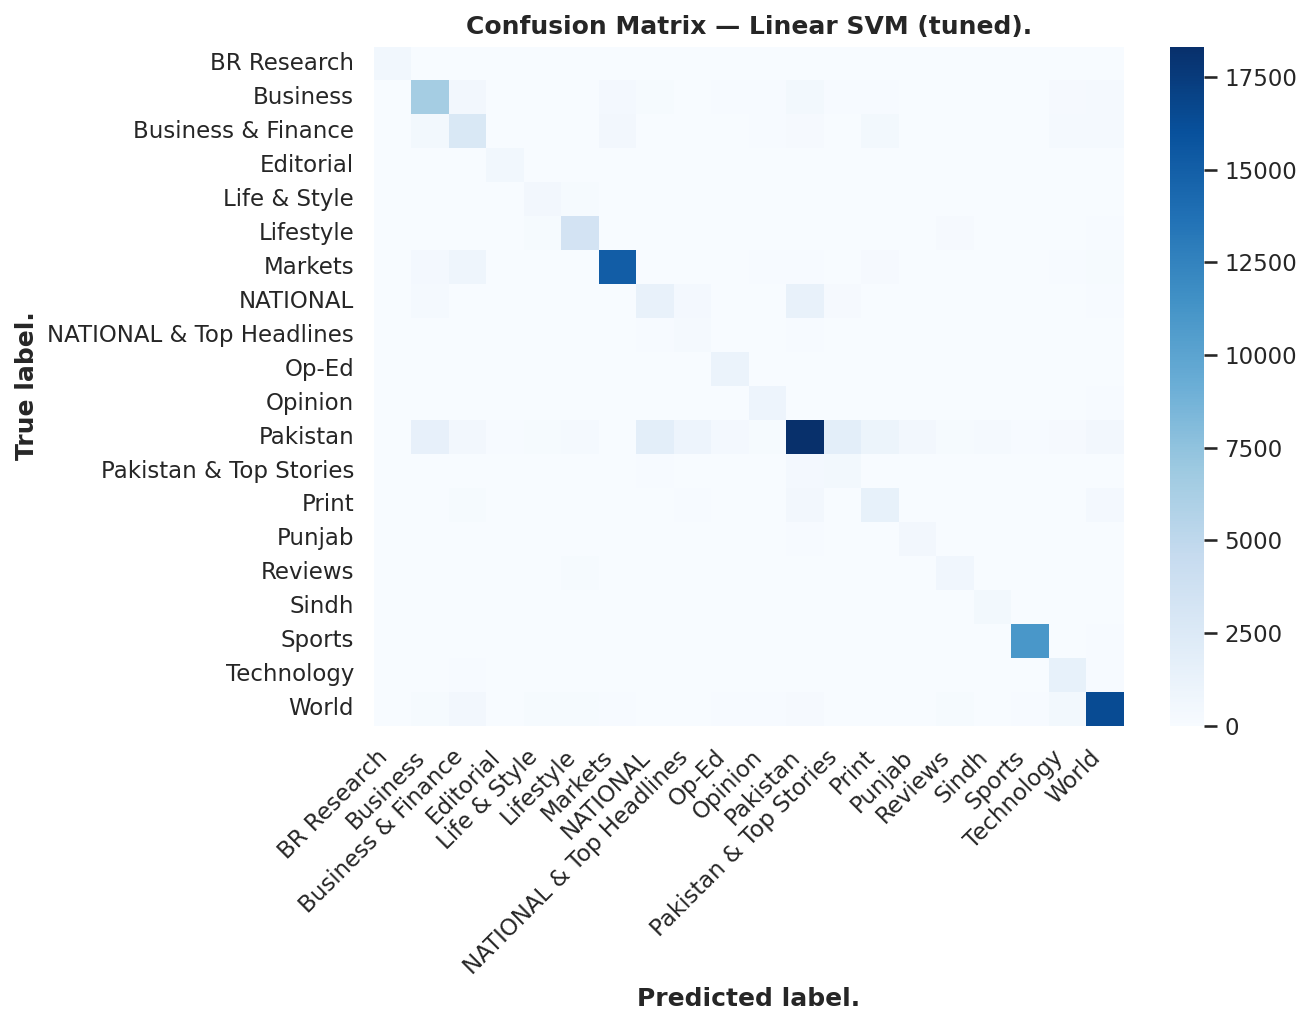

In [ ]:
# Section 6.2: Final Classical Model Evaluation



# Identifies and tells the best classical model.
best_pipeline.fit(X_train, y_train)
classical_preds = best_pipeline.predict(X_test)

print("The Best Classical Model is:", best_name)


# A union of the true labels and the predicted labels for the table.
all_labels = sorted(set(y_test) | set(classical_preds))
target_names = [label_to_category[i] for i in all_labels]

report_dict = classification_report(
    y_test,
    classical_preds,
    labels=all_labels,
    target_names=target_names,
    output_dict = True,
    zero_division = 0,
)


# Styles and displays the table (statistics for cat. prediction).
report_df = pd.DataFrame(report_dict).T

display(
    report_df.style
    .background_gradient(cmap="Blues", subset=["precision", "recall", "f1-score"])
    .format("{:.3f}")
    .set_properties(**{
        "border": "1px solid black",
        "font-size": "12px"
    })
)
print("\n\n")


# Displays a heatmap that shows how good the best model was at predicting category labels.
cm = confusion_matrix(y_test, classical_preds, labels=all_labels)

plt.figure(figsize=(9, 7))
sns.heatmap(
    cm,
    annot=False,
    cmap="Blues",
    xticklabels=[label_to_category[i] for i in all_labels],
    yticklabels=[label_to_category[i] for i in all_labels],
)

plt.title(f"Confusion Matrix — {best_name}.", fontweight="bold")
plt.xlabel("Predicted label.")
plt.ylabel("True label.")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## **7. DistilBERT Fine‑Tuning**


This section adds an powerful experiment using **DistilBERT** for which we:

- Tokenize our cleaned text with a transformer tokenizer.
- Fine‑tune a DistilBERT classifier on the same dataset split as our previous 'dumb' models.
- Evaluate similarly (by using accuracy and macro‑F1) for a fair comparing of our models.

This block is controlled by the `RUN_BERT` flag to keep the notebook lightweight for convenience during testing and debugging.
</br>
</br>
![DistilBERT / BERT encoder stack](https://www.researchgate.net/publication/349990403/figure/fig1/AS:1001068146208771@1615684653748/The-BERT-pre-training-model-based-on-bi-direction-transformer-encoders-E-1-E-2-E-n.png)

**Above:** DistilBERT architecture for the interested of you.

In [ ]:
"""
Section 7: DistilBERT Fine‑Tuning.

B.E.R.T. is an efficient and excellent L.L.M. that compute-poor people like us can locally.
"""



# B.E.R.T. metrics (vars. need initialization, even if not used).
bert_metrics = None
bert_model = None
bert_tokenizer = None


if RUN_BERT:

    # Gets us interpretable output; hides deprecation warnings.
    import warnings
    from transformers.utils import logging as hf_logging

    hf_logging.set_verbosity_error()
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=UserWarning, message=".*pin_memory.*")


    # Installs transformer tooling.
    import torch
    import evaluate
    from datasets import Dataset

    from transformers import (
        AutoModelForSequenceClassification,
        DataCollatorWithPadding,
        TrainingArguments,
        AutoTokenizer,
        Trainer,
    )


    # B.E.R.T runs on the same T.T.S., amongst other things, so results remain comparable.
    model_ckpt = "distilbert-base-uncased"
    bert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

    num_labels = df["label"].nunique()
    bert_model = AutoModelForSequenceClassification.from_pretrained(
        model_ckpt,
        num_labels=num_labels,
    )

    train_ds = Dataset.from_dict(
        {
            "text": X_train.tolist(),
            "label": y_train.tolist(),
        }
    )

    test_ds = Dataset.from_dict(
        {
            "text": X_test.tolist(),
            "label": y_test.tolist(),
        }
    )


    # Tokenizes.
    def tokenize_batch(batch):
        return bert_tokenizer(batch["text"], truncation=True)

    train_ds = train_ds.map(tokenize_batch, batched=True, remove_columns=["text"])
    test_ds = test_ds.map(tokenize_batch, batched=True, remove_columns=["text"])


    # Dynamically padds at batch time.
    collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)
    metric_acc = evaluate.load("accuracy")
    metric_f1 = evaluate.load("f1")


    # Computes statistics on eval. batches.
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis = -1)
        return {
            "accuracy": metric_acc.compute(
                predictions=preds,
                references=labels,
            )["accuracy"],
            "macro_f1": metric_f1.compute(
                predictions=preds,
                references=labels,
                average="macro",
            )["f1"],
        }


    # Model training and evaluation hyperparameters.
    args = TrainingArguments(
        output_dir = "bert_news_out",
        learning_rate= 2e-5,

        per_device_train_batch_size = 16,
        per_device_eval_batch_size = 32,
        num_train_epochs = 2,
        weight_decay = 0.01,

        eval_strategy = "epoch",
        save_strategy = "epoch",

        load_best_model_at_end = True,

        metric_for_best_model = "macro_f1",
        logging_steps = 10,
        report_to = "none",
    )


    # High-level trainer (unionizes the model, data, metrics, and args).
    trainer = Trainer(
        model=bert_model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        tokenizer=bert_tokenizer,
        data_collator=collator,
        compute_metrics=compute_metrics,
    )


    # Calls rel. functions and displays all.
    trainer.train()
    bert_metrics = trainer.evaluate()
    print("BERT evaluation metrics:", bert_metrics)

Map:   0%|          | 0/453996 [00:00<?, ? examples/s]

Map:   0%|          | 0/113499 [00:00<?, ? examples/s]

Streaming output truncated to the last 5000 lines.
{'loss': 0.437, 'grad_norm': 4.184566020965576, 'learning_rate': 1.760035242290749e-05, 'epoch': 0.24}
{'loss': 0.656, 'grad_norm': 2.5493533611297607, 'learning_rate': 1.75968281938326e-05, 'epoch': 0.24035242290748898}
{'loss': 0.5994, 'grad_norm': 5.092599868774414, 'learning_rate': 1.759330396475771e-05, 'epoch': 0.24070484581497797}
{'loss': 0.6897, 'grad_norm': 9.242076873779297, 'learning_rate': 1.758977973568282e-05, 'epoch': 0.24105726872246697}
{'loss': 0.6257, 'grad_norm': 5.190185070037842, 'learning_rate': 1.758625550660793e-05, 'epoch': 0.24140969162995596}
{'loss': 0.5348, 'grad_norm': 7.475342273712158, 'learning_rate': 1.758273127753304e-05, 'epoch': 0.24176211453744492}
{'loss': 0.7142, 'grad_norm': 6.080075263977051, 'learning_rate': 1.757920704845815e-05, 'epoch': 0.2421145374449339}
{'loss': 0.6775, 'grad_norm': 2.1726040840148926, 'learning_rate': 1.757568281938326e-05, 'epoch': 0.2424669603524229}
{'loss': 0.5642

## **8. Model Selection: Classical vs BERT**


Here we decide which model becomes the **final** one:

- If DistilBERT achieves a higher macro‑F1 score, we keep it as `final_model`.
- Otherwise, the tuned classical model is used.

This ensures that the pipeline automatically chooses the strongest approach for our dataset.

In [ ]:
"""
Section 8: Model Selection - Classical vs BERT.

Simply, identifies the best model and tells us so.
"""



final_model_type = "classical"
final_model = best_pipeline

classical_acc = accuracy_score(y_test, classical_preds)
classical_f1 = f1_score(y_test, classical_preds, average="macro")

if bert_metrics is not None:
    bert_f1 = bert_metrics.get("eval_macro_f1", bert_metrics.get("macro_f1", 0.0))
    if bert_f1 >= classical_f1:
        final_model_type = "bert"
        final_model = bert_model
        print("I am keeping BERT as the final model because it performs better.")
    else:
        print("The classical model performs at least as well as BERT, so we will keep it.")
else:
    print("BERT was not run, so we will use the tuned classical model as final.")

print("Final Model Type:", final_model_type)

I am keeping BERT as the final model because it performs better.
Final Model Type: bert


## **9. Prediction Helper for New Articles**


We expose a small helper function `predict_category(text)` that:

- Cleans any input string in the same way as training data.
- Uses the selected final model (classical or BERT).
- Returns the **predicted category name**.

This function can be plugged into a web form, dashboard, or API, and that is what we did that too!

In [ ]:
# Section 9: Plug-and-Play Prediction Helper for New Articles.



def predict_category(text: str) -> str:

    # Returns the pred. cat. for input strings.
    cleaned = clean_text(text)

    if final_model_type == "classical":
        label_idx = int(final_model.predict([cleaned])[0])
        return label_to_category[label_idx]
    else:
        import torch

        # Gets the device that the model is on.
        device = next(final_model.parameters()).device

        inputs = bert_tokenizer(
            [cleaned],
            return_tensors="pt",
            truncation=True,
            padding=True,
        )

        # Moves inputs to the save device as model (cause' BERT lives on GPU but its output is CPU tensors).
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            logits = final_model(**inputs).logits

        label_idx = int(torch.argmax(logits, dim=-1).item())
        return label_to_category[label_idx]


examples = [
    "Pakistan's budget will likely impact fuel prices and investor confidence.",
    "The national cricket team clinched a dramatic victory in Karachi.",
    "A new smartphone with an advanced AI camera has been launched.",
]


# Displays.
for sample in examples:
    print(sample)

    print("→", predict_category(sample))
    print()

Pakistan's budget will likely impact fuel prices and investor confidence.
→ Business

The national cricket team clinched a dramatic victory in Karachi.
→ Sports

A new smartphone with an advanced AI camera has been launched.
→ Technology



## **10. K‑Means Clustering for Latent Topics**


In this block we explore **unsupervised structure** in the news articles:

- Reducing TF‑IDF vectors via Truncated SVD for stability.
- Sweeping several values of `k` and computing their silhouette scores.
- Choosing and applying, by the K-Means algorithm, the best `k`.
- Viewing the latent topics in our dataset through the top terms per cluster.

We mention the insights this gave us, after we interpreted them, in our report.

In [ ]:
tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=0.005,
    max_df=0.95,
    stop_words="english",
)

In [ ]:
# Section 10: Means Clustering for Latent Topics.



# Unsupervised topic discovery and dimensionality reduction via. S.V.M.
X_all = tfidf.fit_transform(df["STORY_CLEAN"])

svd = TruncatedSVD(
    n_components=80,
    random_state=RANDOM_STATE,
)

X_red = svd.fit_transform(X_all)

k_values = list(range(2, 11))
sil_scores = {}

for k in k_values:
    km = KMeans(
        n_clusters=k,
        random_state=RANDOM_STATE,
        n_init="auto",
    )
    labels = km.fit_predict(X_red)
    score = silhouette_score(X_red, labels)
    sil_scores[k] = score


# Displays the silhouette scores by k and the chosen k (based on the scores).
best_k = max(sil_scores, key=sil_scores.get)
print("Silhouette scores by k:", [f"{s:.3f}" for s in sil_scores])
print("Chosen k for clustering:", best_k)


# The K-Means alg. (the k closest points to a new, unlabeled point are of what cat.?).
kmeans = KMeans(
    n_clusters=best_k,
    random_state=RANDOM_STATE,
    n_init="auto",
)
df["cluster"] = kmeans.fit_predict(X_red)

terms = np.array(tfidf.get_feature_names_out())
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

top_terms = {}
for idx in range(best_k):
    top_terms[idx] = terms[order_centroids[idx, :12]].tolist()

cluster_terms = pd.DataFrame(top_terms).T
cluster_terms.index.name = "cluster"
cluster_terms.rename(columns=lambda c: f"term_{c+1}", inplace=True)
(
  cluster_terms.head(10)
  .style
    .set_properties(**{"border": "1px solid black"})
    .set_table_styles(
        [{"selector": "th", "props": [("border", "1px solid black")]}]
    )
)

Silhouette scores by k: ['2.000', '3.000', '4.000', '5.000', '6.000', '7.000', '8.000', '9.000', '10.000']
Chosen k for clustering: 3


,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,term_9,term_10,term_11,term_12
cluster,,,,,,,,,,,,
0,aaj,abandoned,aamir,abbas,abdul,absence,absolutely,academy,absolute,ac,ability,accusing
1,aaj,abbasi,able,abid,abdullah,abu,acceptable,according statement,absence,accelerate,accountability court,absolute
2,aamir,aaj,abroad,accountable,absolutely,abu,abuse,accord,ac,according,achieve,accepting


### **10.1 Cluster Visualization in 2D**


A scatter plot of the first two SVD components shows:

- How articles group into clusters in a low-dimensional space.
- Which clusters are well separated and which are overlapping.

This makes the abstract cluster assignments easier to understand visually. However, SVD components are not interpretable directly. Instead, we use the above table to build a foundation for analyzing this visualizaton.

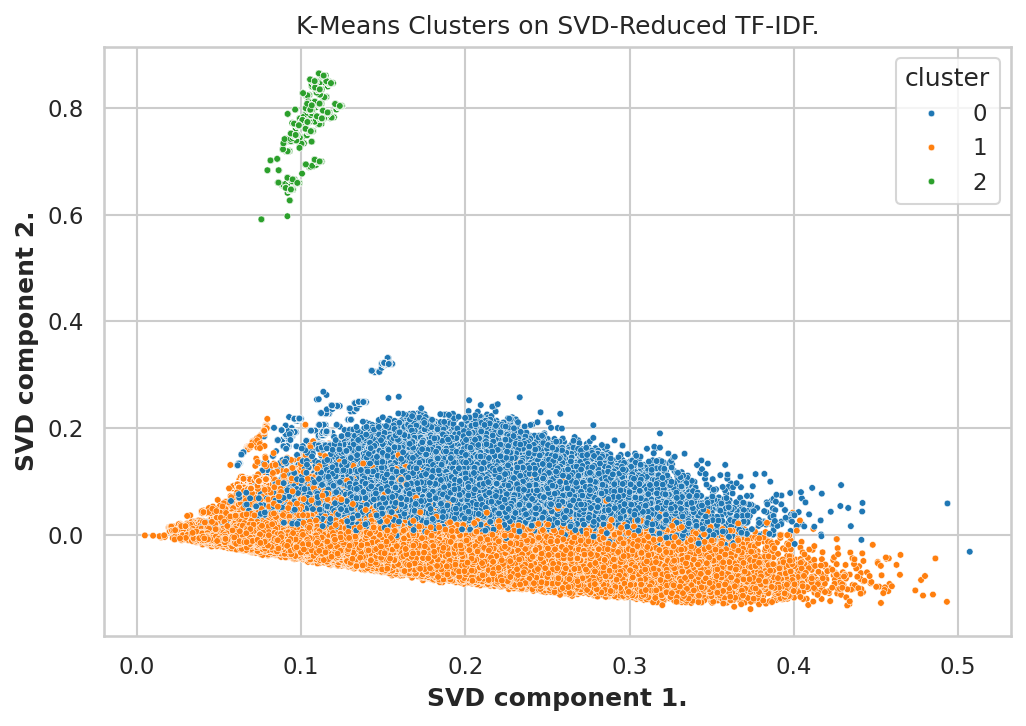

In [ ]:
# Section 10.1: Cluster Visualization in 2D.



plt.figure(figsize=(7, 5))
sns.scatterplot(
    x=X_red[:, 0],
    y=X_red[:, 1],
    hue=df["cluster"],
    s=10,
    palette="tab10",
)

plt.title("K-Means Clusters on SVD-Reduced TF-IDF.")
plt.xlabel("SVD component 1.")
plt.ylabel("SVD component 2.")
plt.tight_layout()
plt.show()

## **11. Frequent Itemsets over Category, Source and Month**


We now perform a simple **association-style analysis** by treating each article as a transaction:

- Items include its category, source and publication month (when available).
- A custom frequent itemset miner computes support for combinations up to size 3.

Only 20 of the strongest, most meaningful associations, intra-ordered from strongest to weakest, are shown. This reveals patterns such as certain outlets focusing on specific topics in particular months. We build upon this, using Lift, in the styled table in Section 11.1.

In [ ]:
# Section 11: Frequent Itemsets over Category, Source and Month.



def extract_items(row) -> List[str]:
    """Create a simple transaction from category, source and month."""
    items = [f"CAT={row['category_clean']}", f"SRC={row['source']}"]
    if pd.notna(row["date_parsed"]):
        items.append(f"MON={row['date_parsed'].to_period('M')}")
    return items


transactions = df.apply(extract_items, axis=1).tolist()


def frequent_itemsets(
    transactions: List[List[str]],
    max_k: int = 3,
    min_support: float = 0.01,
) -> Dict[frozenset, float]:
    """Compute frequent itemsets up to size max_k without extra libraries."""
    n = len(transactions)
    base_counts = Counter()

    for t in transactions:
        base_counts.update(set(t))

    freq_sets = {
        frozenset([item]): count / n
        for item, count in base_counts.items()
        if (count / n) >= min_support
    }

    all_freq = dict(freq_sets)
    k = 2
    current = list(freq_sets.keys())

    while k <= max_k and current:
        candidates = set()
        for a in current:
            for b in current:
                union = a | b
                if len(union) == k:
                    candidates.add(union)

        new_freq = {}
        for cand in candidates:
            count = sum(1 for t in transactions if cand.issubset(t))
            supp = count / n
            if supp >= min_support:
                new_freq[cand] = supp

        all_freq.update(new_freq)
        current = list(new_freq.keys())
        k += 1

    return all_freq


freq_sets = frequent_itemsets(
    transactions,
    max_k=3,
    min_support=MIN_SUPPORT,
)

freq_df = pd.DataFrame(
    [
        {
            "itemset": ", ".join(sorted(list(items))),
            "support": supp,
            "size": len(items),
        }
        for items, supp in freq_sets.items()
    ]
).sort_values(["size", "support"], ascending=[True, False])

(
    freq_df.head(20)
    .style
    .set_properties(**{"border": "1px solid black"})
    .set_table_styles(
        [{"selector": "th", "props": [("border", "1px solid black")]}]
    )
)

,itemset,support,size
2,SRC=Business Recorder,0.443370,1
52,SRC=Daily Times,0.271349,1
4,CAT=Pakistan,0.258291,1
6,CAT=World,0.168149,1
7,CAT=Markets,0.151954,1
59,SRC=Tribune,0.127670,1
5,CAT=Sports,0.099696,1
20,CAT=Business,0.081941,1
56,SRC=Dawn,0.079287,1
57,SRC=Pakistan Today,0.078325,1


### **11.1 Association Rules with Confidence and Lift**


From the frequent itemsets, we derive association rules:

- Each rule has an antecedent, consequent, support, confidence and lift.
- High-lift rules point to especially strong relationships between items such as `CAT=Business` and `SRC=Business Recorder`.

These rules help explain media behavior and source writing styles much beyond classification.

In [ ]:
# Section 11.1: Association Rules with Confidence and Lift.



from itertools import combinations
from typing import Dict


# Finds associations in the dataset (reveals the strongest re-ocurring patterns in the dataset; which cats., srcs., and mons. consistently appear together?).
def association_rules(
    freq_sets: Dict[frozenset, float],
    min_conf: float = 0.2,
) -> pd.DataFrame:
    """Generate simple association rules with confidence and lift."""
    rules = []
    for itemset, supp in freq_sets.items():
        if len(itemset) < 2:
            continue
        items = list(itemset)
        for r in range(1, len(items)):
            for antecedent in combinations(items, r):
                antecedent_set = set(antecedent)
                consequent_set = set(items) - antecedent_set
                supp_a = freq_sets.get(frozenset(antecedent_set), 0.0)
                if supp_a == 0:
                    continue
                conf = supp / supp_a
                supp_c = freq_sets.get(frozenset(consequent_set), 0.0)
                lift = conf / (supp_c if supp_c > 0 else 1e-9)
                if conf >= min_conf:
                    rules.append(
                        {
                            "antecedent": ", ".join(sorted(antecedent_set)),
                            "consequent": ", ".join(sorted(consequent_set)),
                            "support": supp,
                            "confidence": conf,
                            "lift": lift,
                        }
                    )
    return pd.DataFrame(rules).sort_values(
        ["lift", "confidence"],
        ascending=False,
    )


# Styles and displays.
rules_df = association_rules(freq_sets, min_conf=0.2)
rules_df.head(30).style.background_gradient(
    cmap="YlOrRd",
    subset=["support", "confidence", "lift"],
).format("{:.3f}", subset=["support", "confidence", "lift"])

,antecedent,consequent,support,confidence,lift
21,CAT=NATIONAL,SRC=Pakistan Today,0.036,1.000,12.767
22,SRC=Pakistan Today,CAT=NATIONAL,0.036,0.466,12.767
13,CAT=Technology,SRC=Tribune,0.010,0.645,5.049
5,CAT=Op-Ed,SRC=Daily Times,0.010,1.000,3.685
10,CAT=Pakistan & Top Stories,SRC=Daily Times,0.010,1.000,3.685
52,CAT=Lifestyle,SRC=Daily Times,0.036,1.000,3.685
18,CAT=Business,SRC=Pakistan Today,0.021,0.250,3.197
19,SRC=Pakistan Today,CAT=Business,0.021,0.262,3.197
0,CAT=Markets,SRC=Business Recorder,0.152,1.000,2.255
37,CAT=Print,SRC=Business Recorder,0.027,1.000,2.255


## **12. Saving the Final Model and Label Mapping**


Finally, we persist the trained model and label mapping for reuse:

- Classical models are stored as `final_news_model.pkl` .
- BERT models (if used) are saved via `save_pretrained(...)` .
- Category indices are saved in `label_to_category.pkl` .

This step is important for deployment, reproducibility and dashboard integration. We don't skip it!

In [ ]:
# Saving the Final Model and Label Mapping.



if final_model_type == "classical":
    joblib.dump(final_model, "final_news_model.pkl")
else:
    # Saves the transformer's weights and its tokenizer (cause' it's hard to train, so reusability helps).
    final_model.save_pretrained("final_bert_model")
    bert_tokenizer.save_pretrained("final_bert_model")

joblib.dump(label_to_category, "label_to_category.pkl")

print("Saved the final model and label mapping for later use.")

Saved the final model and label mapping for later use.
